<a href="https://colab.research.google.com/github/jramassa/ml-student/blob/main/BE_session1_probleme1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problème 1:





Dans ce problème, il s'agit de reconstruire un champ spatialisé cible à partir d'un prédicteur spatialisé et d'observations ponctuelles.  
Dans la première partie, on adapte simplement la procédure de régression pixel à pixel standard au cas où les données cibles ne sont renseignées qu'en quelques pixels (observations "ponctuelles").\
Dans la seconde partie, on entraîne un réseau à prendre les deux types de données, champ spatialisé et observations ponctuelles, en entrée pour reconstruire au mieux la cible complète.

**NB**: Il vaut mieux traiter les deux parties dans l'ordre.

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt

In [2]:
! wget https://www.grosfichiers.com/mfh8gy5ZmfB_zaQP9HZKdDk
! mv mfh8gy5ZmfB_zaQP9HZKdDk utile_BE.py

from utile_BE import *

--2024-01-12 14:29:14--  https://www.grosfichiers.com/mfh8gy5ZmfB_zaQP9HZKdDk
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21240 (21K) [application/octet-stream]
Saving to: ‘mfh8gy5ZmfB_zaQP9HZKdDk’

mfh8gy5ZmfB_zaQP9HZ 100%[===================>]  20.74K  --.-KB/s    in 0s      

2024-01-12 14:29:14 (285 MB/s) - ‘mfh8gy5ZmfB_zaQP9HZKdDk’ saved [21240/21240]



## Partie I : régression sur une cible incomplète

La fonction *gen1* permet d'échantillonner des données d'apprentissage.\
Le paramètre *p* représente la proportion de pixels au niveau desquels les observations ponctuelles sont disponibles. Ces observations ponctuelles, contenues dans le deuxième tenseur fourni par *gen1*, sont positives ou nulles. Les pixels où elles manquent sont associés à la valeur -1.\
Le troisième tenseur correspond à la cible complète (cas idéal où *p*=1). C'est elle qu'on cherche à prédire.

**NB**:
- le deuxième tenseur est une version incomplète du troisième tenseur.
- *gen1* peut être considéré comme un échantillonneur parfait des données d'apprentissage. Il ne produit jamais deux fois les mêmes images.

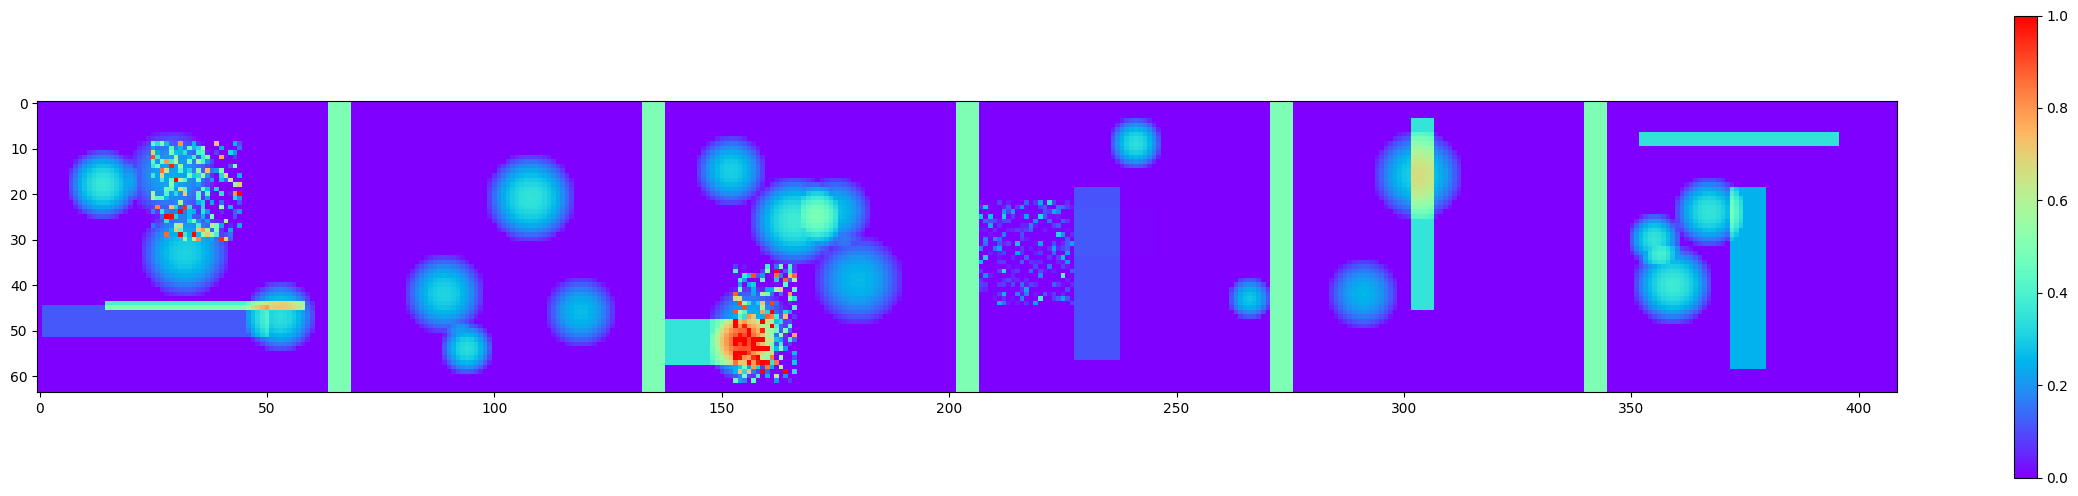

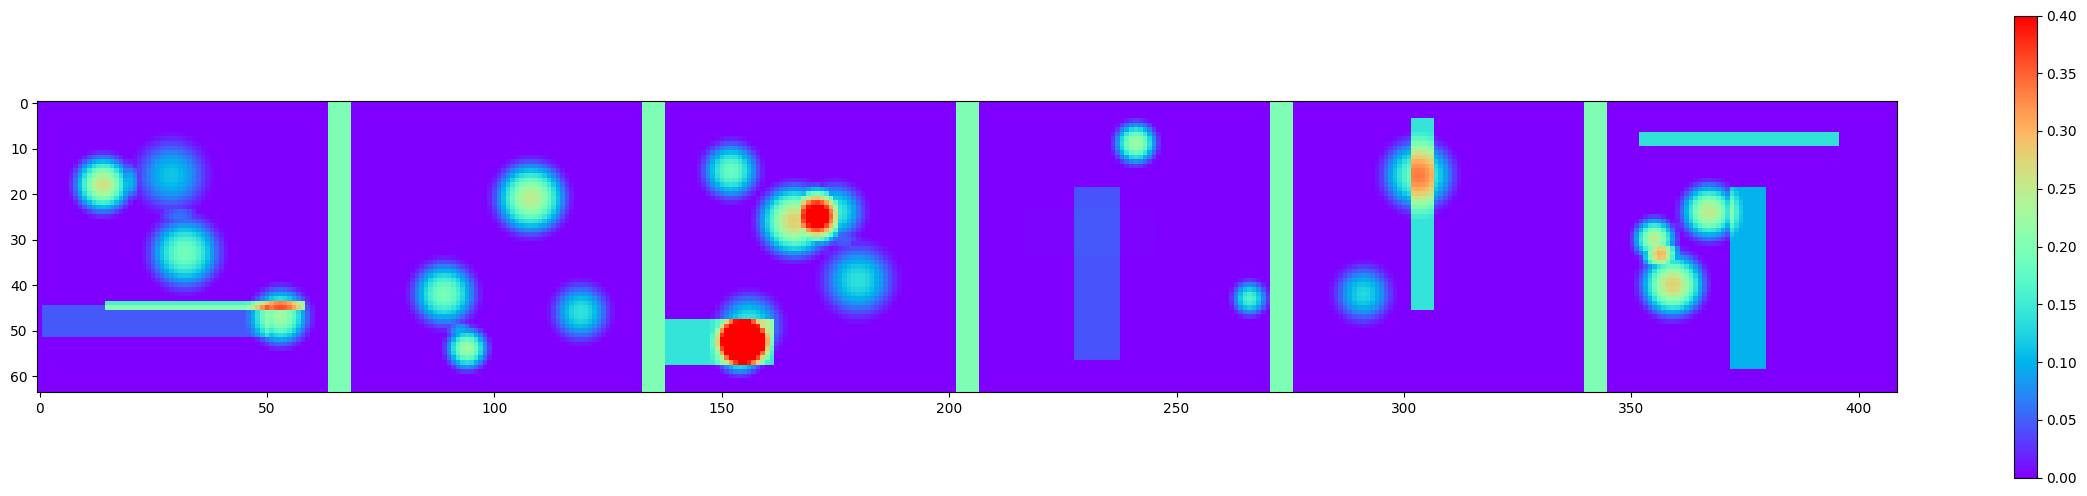

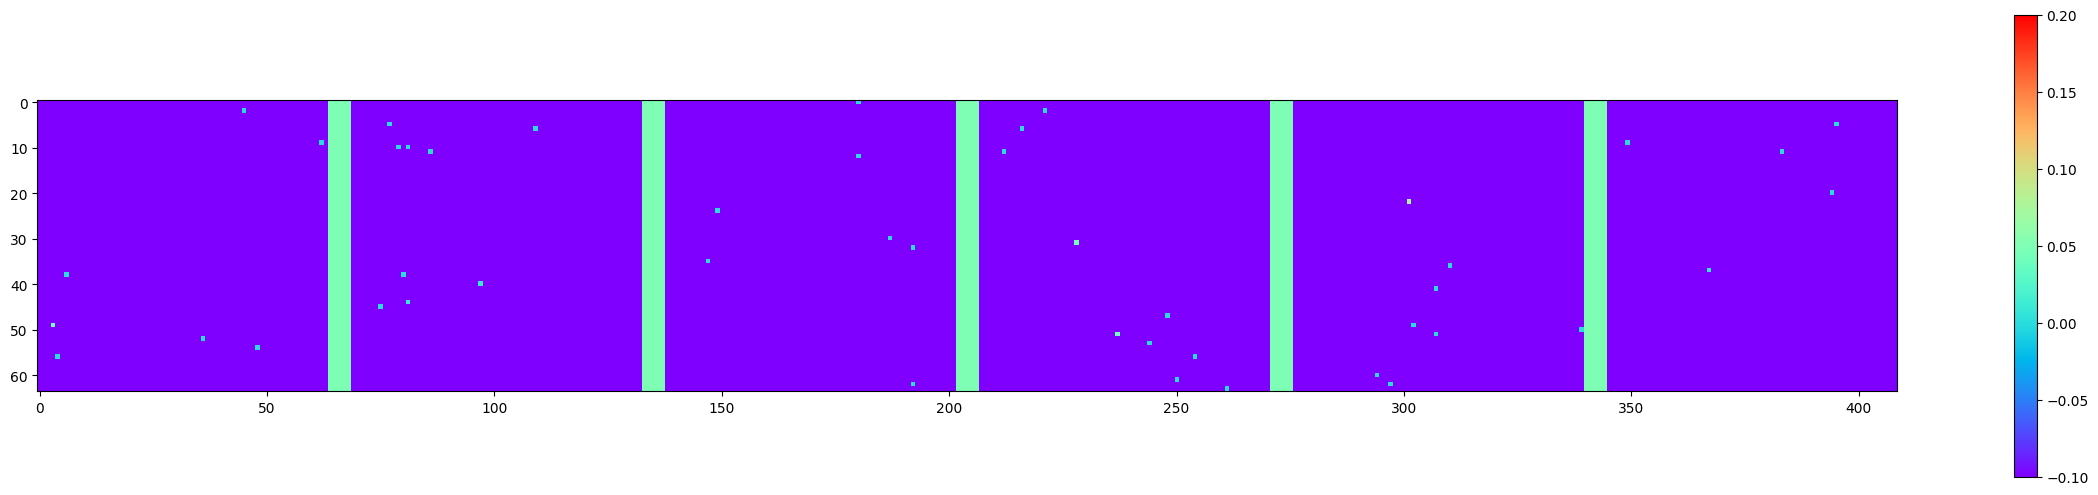

In [3]:
input,  target, fulltarget  = gen1(6,p=0.002)

# input: prédicteur spatialisé
fig0 = plt.figure(0, figsize=(30, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0, max_scale=1)

# fulltarget: cible complète, qu'on ne peut pas utiliser pour l'apprentissage
fig1 = plt.figure(1, figsize=(30, 6))
voir_batch2D(fulltarget, 6, fig1, k=0, min_scale=0, max_scale=0.4)

# target: cible incomplète
fig2 = plt.figure(2, figsize=(30, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=-0.1, max_scale=0.2)

**Q1** Pour entraîner un réseau de neurones sur des cibles incomplètes, on définit la fonction de coût *masked_MAE*.
Préciser le rôle du tenseur *mask*. Tester le bon fonctionnement de *masked_MAE* à l'aide d'un batch généré par *gen1*.
       


Le tenseur mask est un tenseur booléen qui inique où se trouvent les mesures sur les cibles.

In [4]:
def masked_MAE(output, target, mask):
  return (torch.abs(output-target))[mask].mean()

In [5]:
# Test du bon fonctionnement de masked_MAE
input,  target, fulltarget  = gen1(6,p=0.002)
mask = (target >= 0)
print(masked_MAE(fulltarget, target, mask)) # égale 0 car on calcule la loss avec la cible complète (ce qu'on veut obtenir)

tensor(0.)


**Q2** Pour cette tâche de régression, nous allons entraîner un UNet. Précisez les différentes couches contenues dans ce UNet, leur rôle et le nombre de poids total qu'il contient.

In [6]:
fcn = UNet(1,1,16)
print(fcn)

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): Down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32

Ce UNet contient les couches suivantes :
  - couche de convolution (Conv2d) : applique des noyaux sur le batch d'images (ces noyaux sont considérés comme des neurones et sont donc des paramètres entraînables. En l'occurence, ils donnent des éléments appelés features map susceptibles de repérer des éléments caractéristiques de l'image (contour, contraste...)).
  - couche de convolution transposée (ConvTranspose2d) : fournit également des features map dont la dimesion spatiale sera le double de celle de l'image d'entrée (stride = 2)
  - couche de normalisation (BatchNorm2d) : centre et réduit les images du batch avec la moyenne et l'écart-type calculée sur le batch
  - couche de maxpooling (MaxPool2d) : garde la valeur maximale des sous-tenseurs définies de l'image d'entrée par la taille du noyau (ici 2), ceci a pour conséquence une réduction de la taille de l'image de 2 longueur et largeur
  - couche fonction d'activation non-linéaire (ReLU) : garde les valeurs positives (donne 0 si la valeur est négative)

In [7]:
nb_weights = 0
for module in fcn.modules():
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.BatchNorm2d):
    for parameter in module.parameters():
      nb_weights += torch.numel(parameter)
print('Le nombre de poids total est ', nb_weights)

Le nombre de poids total est  926786


**Q3** Dans la fonction *run_train* coder une époque de l'entraînement du UNet en exploitant la cible incomplète. Rester sur CPU. **Commenter votre code**. \
On utilisera les hyperparamètres suivants :

In [8]:
# optim: Adam, lr = 0.001
# batch par époque: 50
# taille d'un batch: 64
# p = 0.002
lr = 0.001
batchsize = 64
nbatches = 50
p = 0.002
optimizer = optim.Adam(fcn.parameters(), lr)

In [9]:
def run_train(fcn, optimizer, p = 0.002):

  epoch_losses = []
  for i in range(nbatches):    # nombre de batches par époque

    # annuler les gradients
    optimizer.zero_grad()

    # obtention des entrées et des cibles par génération
    input,  target, _ = gen1(batchsize, p)

    # utilisation du modèle
    output = fcn(input)

    # calcul du mask (là où il y a des mesures)
    mask = (target >= 0)

    # calcul du coût
    loss = masked_MAE(output, target, mask)

    # calcul des gradients
    loss.backward()

    # mise à jour des poids
    optimizer.step()


    epoch_losses.append(loss.detach())

    # supprimer les données devenues inutiles
    del target, input, loss

  # perte moyenne sur l'epoch
  epoch_loss = np.mean(epoch_losses)

  print('epoch loss : \n')
  print(epoch_loss)

  return fcn, optimizer

In [10]:
...

Ellipsis

In [11]:
import time
t = time.time()
run_train(fcn, optimizer, p = 0.002)
print(time.time() - t)

epoch loss : 

0.06962685
106.57176375389099


**Q4** Dans la fonction *run_train_gpu*, passer la phase d'entraînement sur GPU. Evaluer le speed-up.

In [12]:
def run_train_gpu(fcn, optimizer, p = 0.002):

  epoch_losses = []
  for i in range(nbatches):    # nombre de batches par époque

    # annuler les gradients
    optimizer.zero_grad()

    # obtention des entrées et des cibles par génération
    input,  target, _ = gen1(batchsize, p)

    # passer sur le carte GPU
    input = input.cuda()
    target = target.cuda()

    # utilisation du modèle
    output = fcn(input)

    # calcul du mask (là où il y a des mesures)
    mask = (target >= 0)

    # calcul du coût
    loss = masked_MAE(output, target, mask)

    # calcul des gradients
    loss.backward()

    # mise à jour des poids
    optimizer.step()


    epoch_losses.append(loss.detach().cpu())

    # supprimer les données devenues inutiles
    del target, input, loss

  # perte moyenne sur l'epoch
  epoch_loss = np.mean(epoch_losses)

  print('epoch loss : \n')
  print(epoch_loss)

  return fcn, optimizer

In [13]:
fcn = fcn.cuda()
optimizer = optim.Adam(fcn.parameters(), lr)

In [14]:
# pour le calcul du speed-up
import time
t = time.time()
run_train_gpu(fcn, optimizer, p = 0.002)
print(time.time() - t)

epoch loss : 

0.018151676
11.43880844116211


Le speed-up est significatif, on constate une amélioration d'un facteur 10 (exécution 10 fois plus rapide)

Dans les questions suivantes, nous allons chercher à évaluer l'effet de la densité des observations ponctuelles *p* sur les performances en généralisation au cours de l'entraînement.

**Q5**  Pour comparer les performances en généralisation au cours de l'entraînement, on se permet d'utilise la MAE entre outputs et cibles **complètes**. En général, peut-on se permettre d'utiliser les mêmes données que celles qui ont été utilisées pendant la phase d'entraînement ? Est-ce le cas ici ? \
Dans la fonction *run_trainval_gpu()* suivante, évaluer les performances en généralisation au cours de l'entraînement (variable *epoch_MAE_validation*).
Eviter tout calcul superflux.

En général, il ne faut pas utiliser les mêmes données que celles qui ont été utilisées pendant la phase d'entraînement car habituellement, on dispose d'un ensemble de données limité. Comme l'entraînement se fait sur un ensemble restreint, le modèle sera entraîné uniquement sur cet ensemble par essence limité et pourrait donner de mauvais résultats sur de nouvelles images (généralement celles de validation et de test), c'est le cas lorsqu'il y a un surapprentissage. En revanche, ici les images sont générées à la volée et on dispose donc d'un ensemble "infinie" pour l'entraînement. On peut donc réutiliser le même générateur pour évaluer les performances sans se soucier du risque de surapprentissage.

In [16]:
def run_trainval_gpu(fcn, optimizer, p = 0.002):

  epoch_losses = []
  epoch_MAE_validations = []
  for i in range(nbatches):    # nombre de batches par époque

    # phase entraînement

    # annuler les gradients
    optimizer.zero_grad()

    # obtention des entrées et des cibles par génération
    input,  target, _ = gen1(batchsize, p)

    # passer sur le carte GPU
    input = input.cuda()
    target = target.cuda()

    # utilisation du modèle
    output = fcn(input)

    # calcul du mask (là où il y a des mesures)
    mask = (target >= 0)

    # calcul du coût
    loss = masked_MAE(output, target, mask)

    # calcul des gradients
    loss.backward()

    # mise à jour des poids
    optimizer.step()


    epoch_losses.append(loss.detach().cpu())

    # supprimer les données devenues inutiles
    del target, input, loss

    # phase validation

    # calcul de gradients inutile ici
    with torch.no_grad():

      # annuler les gradients
      optimizer.zero_grad()

      # obtention des entrées et des cibles par génération
      input,  target, fulltarget = gen1(batchsize, p)

      # passer sur le carte GPU
      input = input.cuda()
      target = target.cuda()
      fulltarget = fulltarget.cuda()

      # utilisation du modèle
      output = fcn(input)

      # MAE de validation
      MAE_validation = torch.mean(torch.abs(output - fulltarget))

      epoch_MAE_validations.append(MAE_validation.detach().cpu())


  # perte moyenne sur l'epoch
  epoch_loss = np.mean(epoch_losses)

  # MAE validation moyenne
  epoch_MAE_validation = np.mean(epoch_MAE_validations)

  print('epoch loss : \n')
  print(epoch_loss)

  print('epoch MAE validation : \n')
  print(epoch_MAE_validation)

  return fcn, optimizer, epoch_MAE_validation

In [17]:
fcn, optimizer, MAE_validation = run_trainval_gpu(fcn, optimizer, p = 0.002)


epoch loss : 

0.011259926
epoch MAE validation : 

0.011235042


**Q6** Générer deux versions du UNet précédent comportant les **mêmes poids initiaux**. Entraîner ces versions sur cinquante époques, chacun pour une valeur de *p* différente : *p* = 0.01 et *p* = 0.002.
**Commenter votre code**. Tracer et discuter les courbes d'apprentissage.

epoch loss : 

0.091353655
epoch MAE validation : 

0.08387565
epoch loss : 

0.049458016
epoch MAE validation : 

0.045928553
epoch loss : 

0.017833658
epoch MAE validation : 

0.017671356
epoch loss : 

0.018215312
epoch MAE validation : 

0.017851558
epoch loss : 

0.014141683
epoch MAE validation : 

0.013551754
epoch loss : 

0.01430277
epoch MAE validation : 

0.01444329
epoch loss : 

0.012950436
epoch MAE validation : 

0.0125283515
epoch loss : 

0.012623586
epoch MAE validation : 

0.011947652
epoch loss : 

0.012059727
epoch MAE validation : 

0.01179125
epoch loss : 

0.009996928
epoch MAE validation : 

0.010251909
epoch loss : 

0.013437826
epoch MAE validation : 

0.0137229785
epoch loss : 

0.009252745
epoch MAE validation : 

0.00916202
epoch loss : 

0.011112504
epoch MAE validation : 

0.011164449
epoch loss : 

0.00892711
epoch MAE validation : 

0.008634713
epoch loss : 

0.011704373
epoch MAE validation : 

0.011476708
epoch loss : 

0.009093853
epoch MAE validat

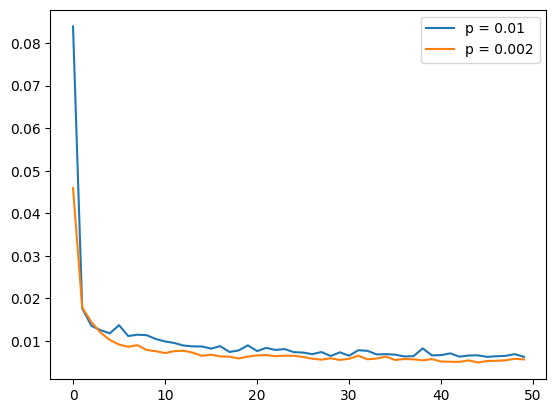

In [18]:
nepochs = 50
scores_1  = []
scores_2  = []

# mêmes poids initiaux
fcn = UNet(1,1,16)
fcn2 = UNet(1,1,16)

# vers carte GPU
fcn = fcn.cuda()
fcn2 = fcn2.cuda()

# un optimiseur chacun
optimizer = optim.Adam(fcn.parameters(), lr)
optimizer2 = optim.Adam(fcn2.parameters(), lr)

for epoch in range(nepochs):

  print("Epoch " + str(epoch))

  fcn, optimizer, MAE_validation = run_trainval_gpu(fcn, optimizer, p = 0.01)

  scores_1.append(MAE_validation)

  fcn2, optimizer2, MAE_validation2 = run_trainval_gpu(fcn2, optimizer2, p = 0.002)

  scores_2.append(MAE_validation2)

plt.plot(scores_1)
plt.plot(scores_2)
plt.legend(['p = 0.01', 'p = 0.002'])



**Q7** Combien faut-il d'époques supplémentaires au deuxième *fcn* pour rattraper le premier ?

In [24]:
MAE_premier = scores_1[len(scores_1) - 1]
MAE_second = scores_2[len(scores_2) - 1]
epoch_supp = 0
while MAE_second >= MAE_premier:
  epoch_supp += 1
  print("Epoch supplémentaire" + str(epoch_supp))
  fcn2, optimizer2, MAE_second = run_trainval_gpu(fcn2, optimizer2, p = 0.002)

print('Il faut au deuxième fcn ', epoch_supp, ' supplémentaires')

Il faut au deuxième fcn  0  supplémentaires


## **Partie II** : cas où les observations ponctuelles peuvent aussi servir d'entrées.

Dans cette partie, nous supposons que les observations ponctuelles sont disponibles non seulement pendant l'apprentissage, mais aussi en phase d'inférence.
Il devient donc possible de l'utiliser comme une entrée.

Avec la fonction *gen2*, cela va même s'avérer nécessaire : les observations ponctuelles contiennent une information essentielle à la prédiction de la cible complète.

En effet, le premier tenseur founi par *gen2* (ligne 1 ci-dessous) permet de dire où sont les pixels associés à des valeurs non nulles dans la cible complète (ligne 2).
Par contre, ce premier tenseur ne suffit pas à préciser l'intensité du signal cible : pour certaines cellules (premier type de cellules, en rouge sur la troisième ligne) le signal cible est plus fort que sur le premier tenseur, alors que pour d'autres cellules (deuxième type de cellule, en cyan), il est plus faible. Et rien dans le premier tenseur n'indique à quel type de cellule on a affaire.

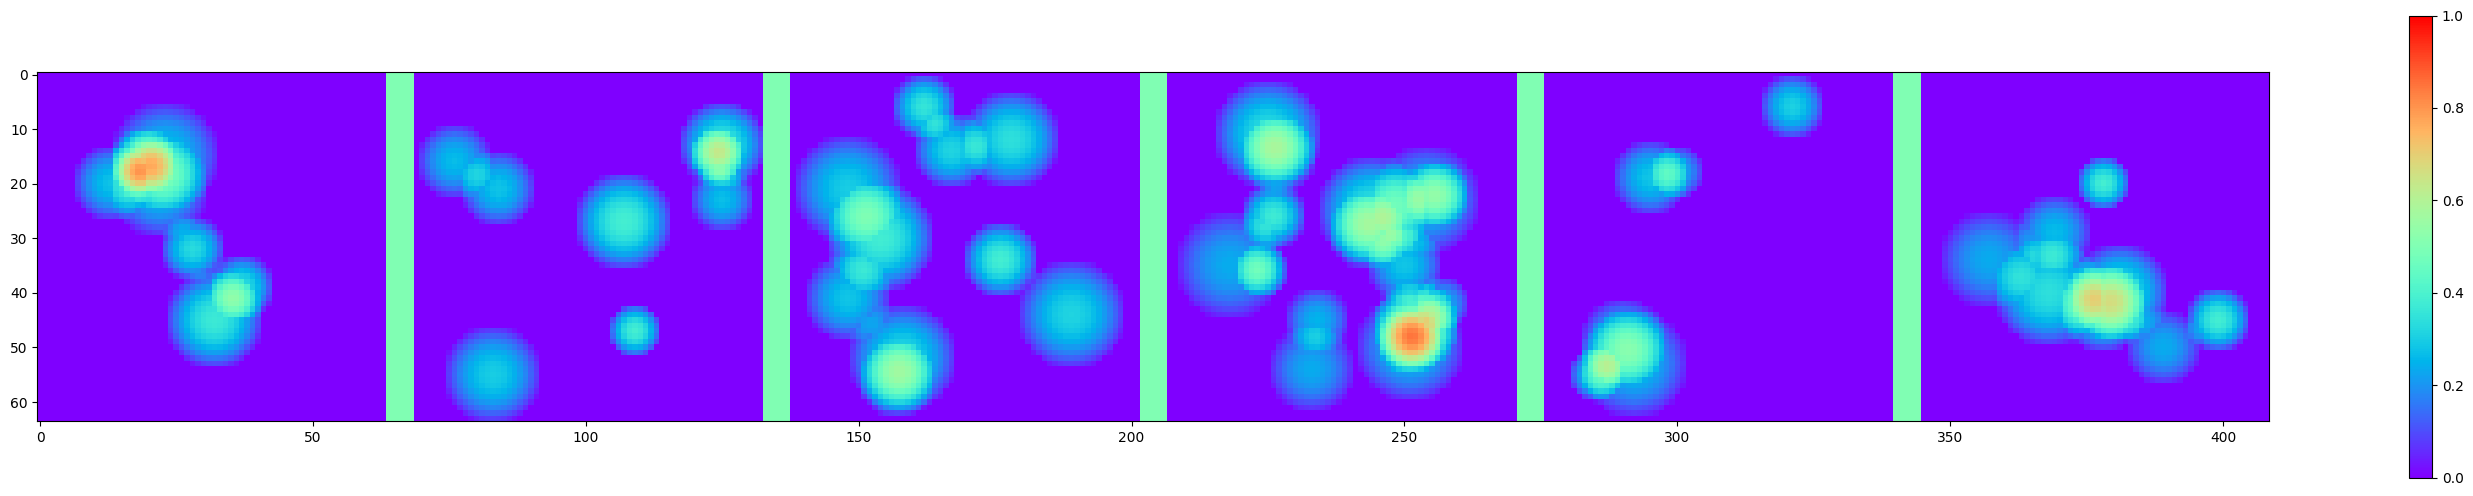

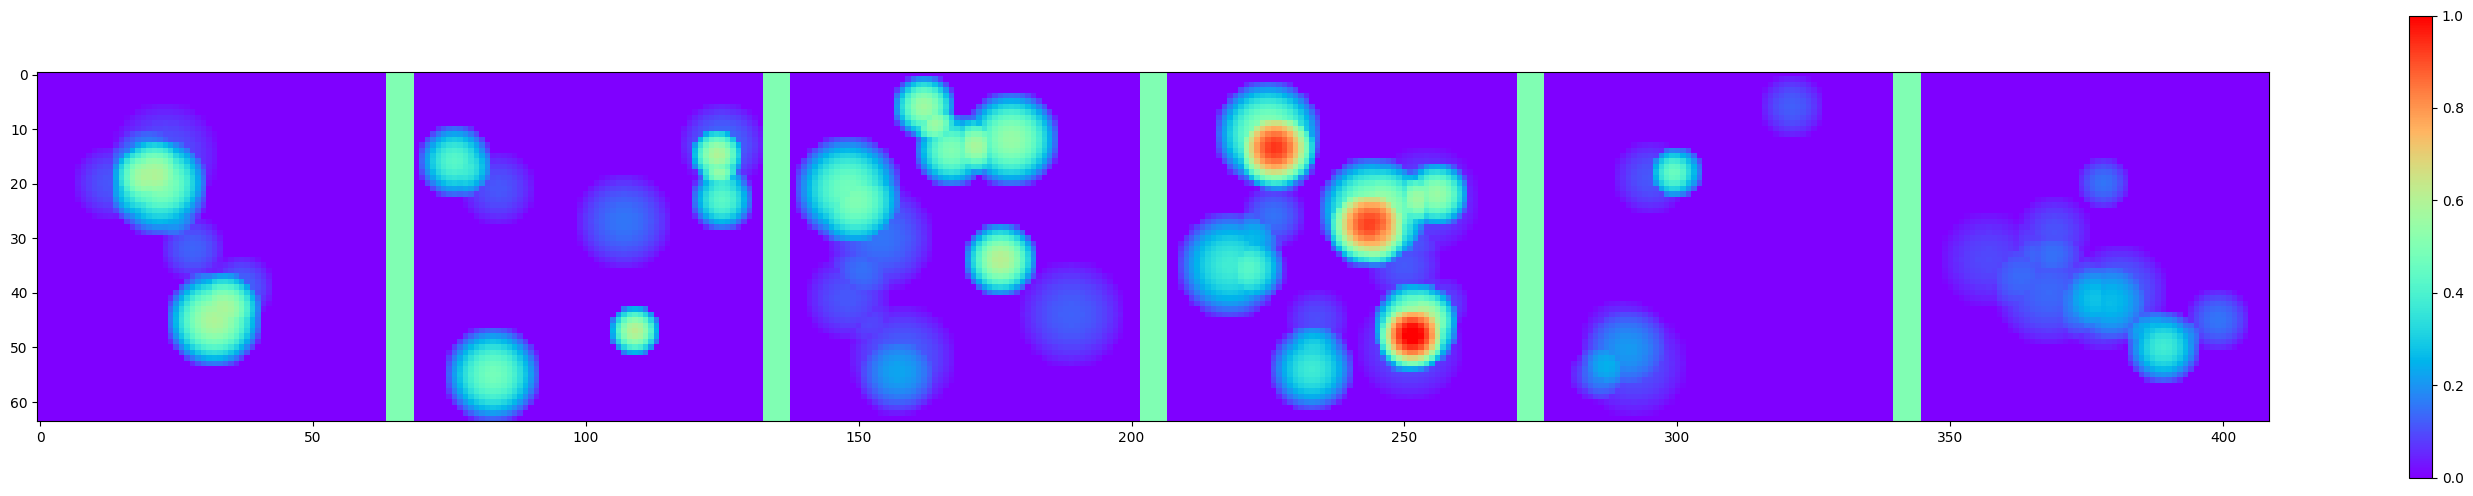

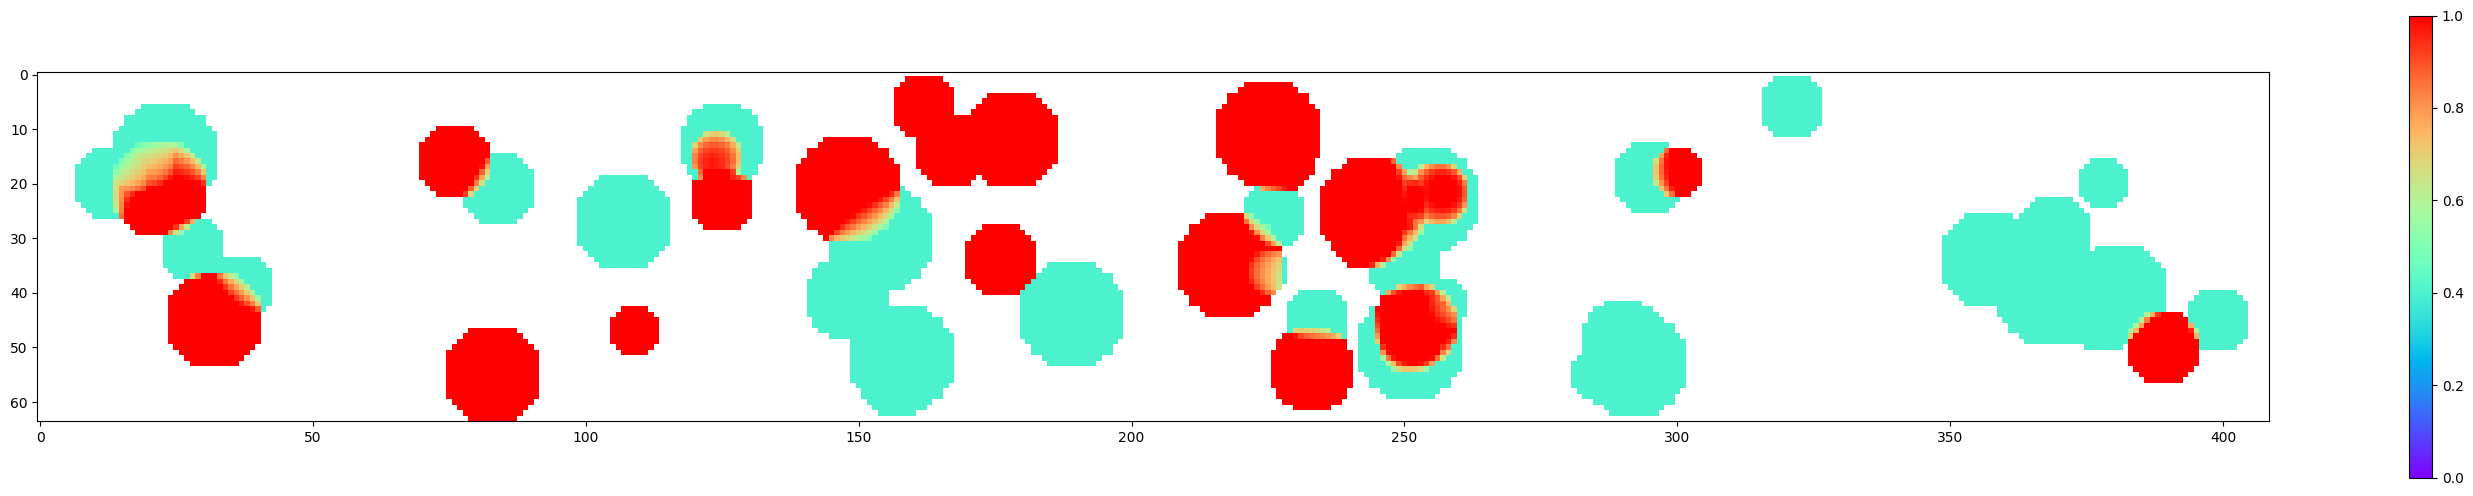

In [25]:
input, target, fulltarget  = gen2(6,0.01)

# ligne 1: le prédicteur spatialisé
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ligne 2: le signal cible complet où les deux types de cellules apparaissent
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(fulltarget, 6, fig1, k=0, min_scale=0,max_scale=1)

# ligne 3: le rapport entre les deux
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D((fulltarget/input), 6, fig1, k=0, min_scale=0,max_scale=1)

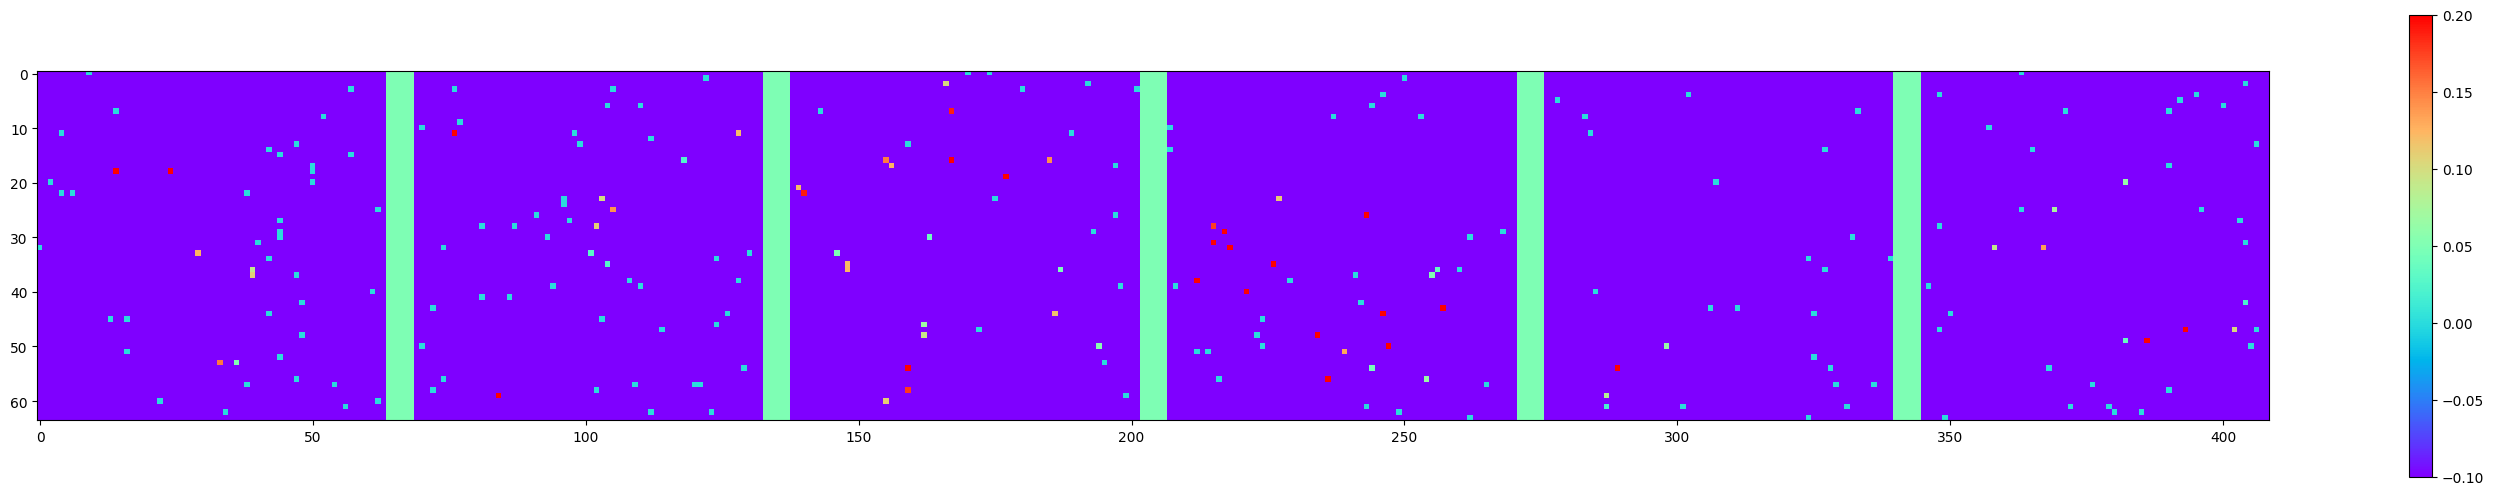

In [26]:
# les observations ponctuelles:
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=-0.1,max_scale=0.2)

Comme dans la partie I, les observations ponctuelles sont les seules parties de la cible disponibles au cours de l'entraînement. Mais, comme expliqué au-dessus, ces observations ponctuelles seront aussi disponibles en phase d'inférence. Comme elles contiennent une information essentielle, il va donc s'agir d'entraîner le réseau à les exploiter à la fois comme cibles et comme entrées.


**NB:** De même que dans la partie I, dans le deuxième tenseur les valeurs manquantes sont codées par -1 et toutes les autres valeurs sont positives ou nulles.

**Q1** Dans un premier temps, entraîner un UNet **en n'utilisant que le premier tenseur ("input") en entrée**. Toutes les observations ponctuelles disponibles peuvent être utilisées dans la cible.
Les autres consignes sont :
- Choisir la fonction de coût de manière à estimer la **moyenne conditionnelle à l'entrée**.
- Pour la phase de validation, évaluer l'écart entre la cible complète et les outputs de la phase d'entraînement (comme dans la partie I).
- Utiliser les hyperparamètres ci-dessous:

In [27]:
import torch.optim as optim
fcn = UNet(1,1,16)
nepochs = 15
nbatches = 100
batchsize = 64
p = 0.01

In [34]:
# fonction de coût
def moyenne_cond(output, target):
  return torch.mean(torch.abs(output - target))

In [35]:
scores_1  = []

def run_trainval_gpu2(fcn, optimizer, p):

  epoch_losses = []
  epoch_MAE_validations = []
  for i in range(nbatches):    # nombre de batches par époque

    # phase entraînement

    # annuler les gradients
    optimizer.zero_grad()

    # obtention des entrées et des cibles par génération
    input,  target, _ = gen2(batchsize, p)

    # passer sur le carte GPU
    input = input.cuda()
    target = target.cuda()

    # utilisation du modèle
    output = fcn(input)

    # calcul du coût
    loss = moyenne_cond(output, target)

    # calcul des gradients
    loss.backward()

    # mise à jour des poids
    optimizer.step()


    epoch_losses.append(loss.detach().cpu())

    # supprimer les données devenues inutiles
    del target, input, loss

    # phase validation

    # calcul de gradients inutile ici
    with torch.no_grad():

      # annuler les gradients
      optimizer.zero_grad()

      # obtention des entrées et des cibles par génération
      input,  target, fulltarget = gen2(batchsize, p)

      # passer sur le carte GPU
      input = input.cuda()
      target = target.cuda()
      fulltarget = fulltarget.cuda()

      # utilisation du modèle
      output = fcn(input)

      # MAE de validation
      MAE_validation = torch.mean(torch.abs(output - fulltarget))

      epoch_MAE_validations.append(MAE_validation.detach().cpu())


  # perte moyenne sur l'epoch
  epoch_loss = np.mean(epoch_losses)

  # MAE validation moyenne
  epoch_MAE_validation = np.mean(epoch_MAE_validations)

  print('epoch loss : \n')
  print(epoch_loss)

  print('epoch MAE validation : \n')
  print(epoch_MAE_validation)

  return fcn, optimizer, epoch_MAE_validation

Epoch 0
epoch loss : 

5.1097074
epoch MAE validation : 

6.123757
Epoch 1
epoch loss : 

2.4811327
epoch MAE validation : 

3.4889755
Epoch 2
epoch loss : 

1.0768284
epoch MAE validation : 

2.0391047
Epoch 3
epoch loss : 

0.5367393
epoch MAE validation : 

1.4585738
Epoch 4
epoch loss : 

0.1490142
epoch MAE validation : 

1.089673
Epoch 5
epoch loss : 

0.07264181
epoch MAE validation : 

1.0689205
Epoch 6
epoch loss : 

0.06417796
epoch MAE validation : 

1.0675051
Epoch 7
epoch loss : 

0.051742487
epoch MAE validation : 

1.0610397
Epoch 8
epoch loss : 

0.05412221
epoch MAE validation : 

1.0670882
Epoch 9
epoch loss : 

0.046987757
epoch MAE validation : 

1.0630603
Epoch 10
epoch loss : 

0.04274704
epoch MAE validation : 

1.0631665
Epoch 11
epoch loss : 

0.03674614
epoch MAE validation : 

1.060969
Epoch 12
epoch loss : 

0.034851503
epoch MAE validation : 

1.0615625
Epoch 13
epoch loss : 

0.031058788
epoch MAE validation : 

1.0622689
Epoch 14
epoch loss : 

0.03141867

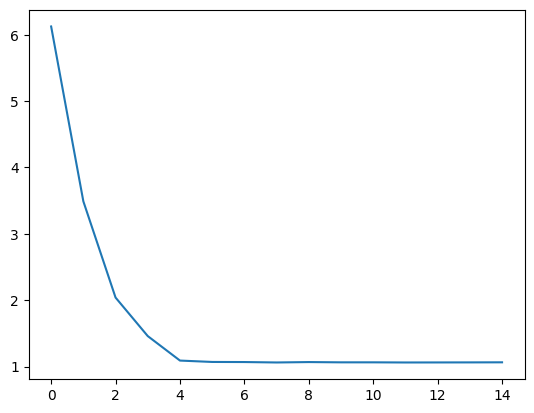

In [36]:
# vers carte GPU
fcn = fcn.cuda()

# un optimiseur chacun
optimizer = optim.Adam(fcn.parameters(), lr)

for epoch in range(nepochs):

  print("Epoch " + str(epoch))

  fcn, optimizer, MAE_validation = run_trainval_gpu2(fcn, optimizer, p)

  scores_1.append(MAE_validation)

plt.plot(scores_1)

**Q2** Pourquoi les performances stagnent-elles ? Visualiser quelques outputs et vérifier que le réseau restitue simplement le champ d'entrée. Expliquer pourquoi, intuitivement.

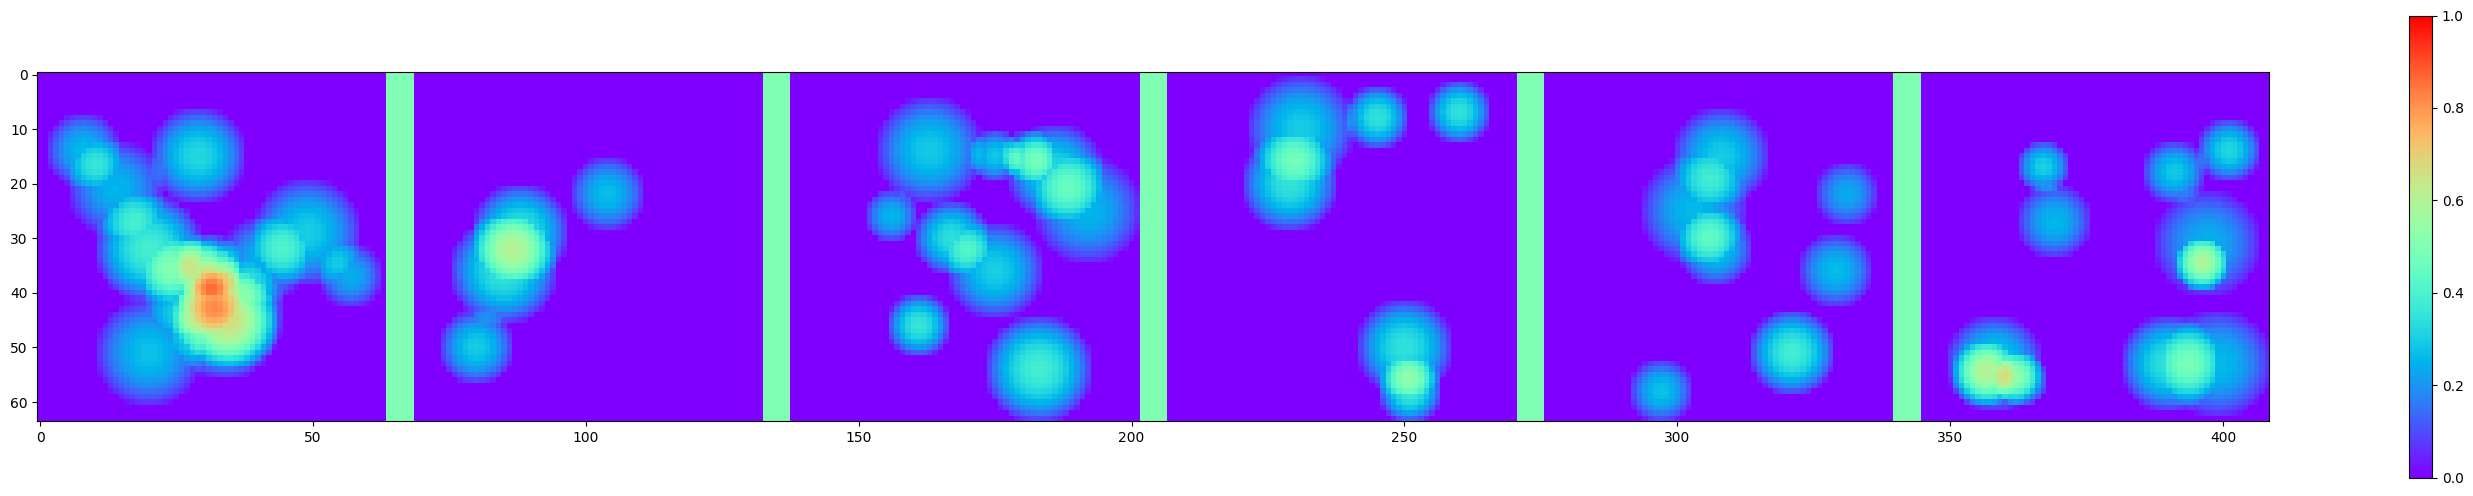

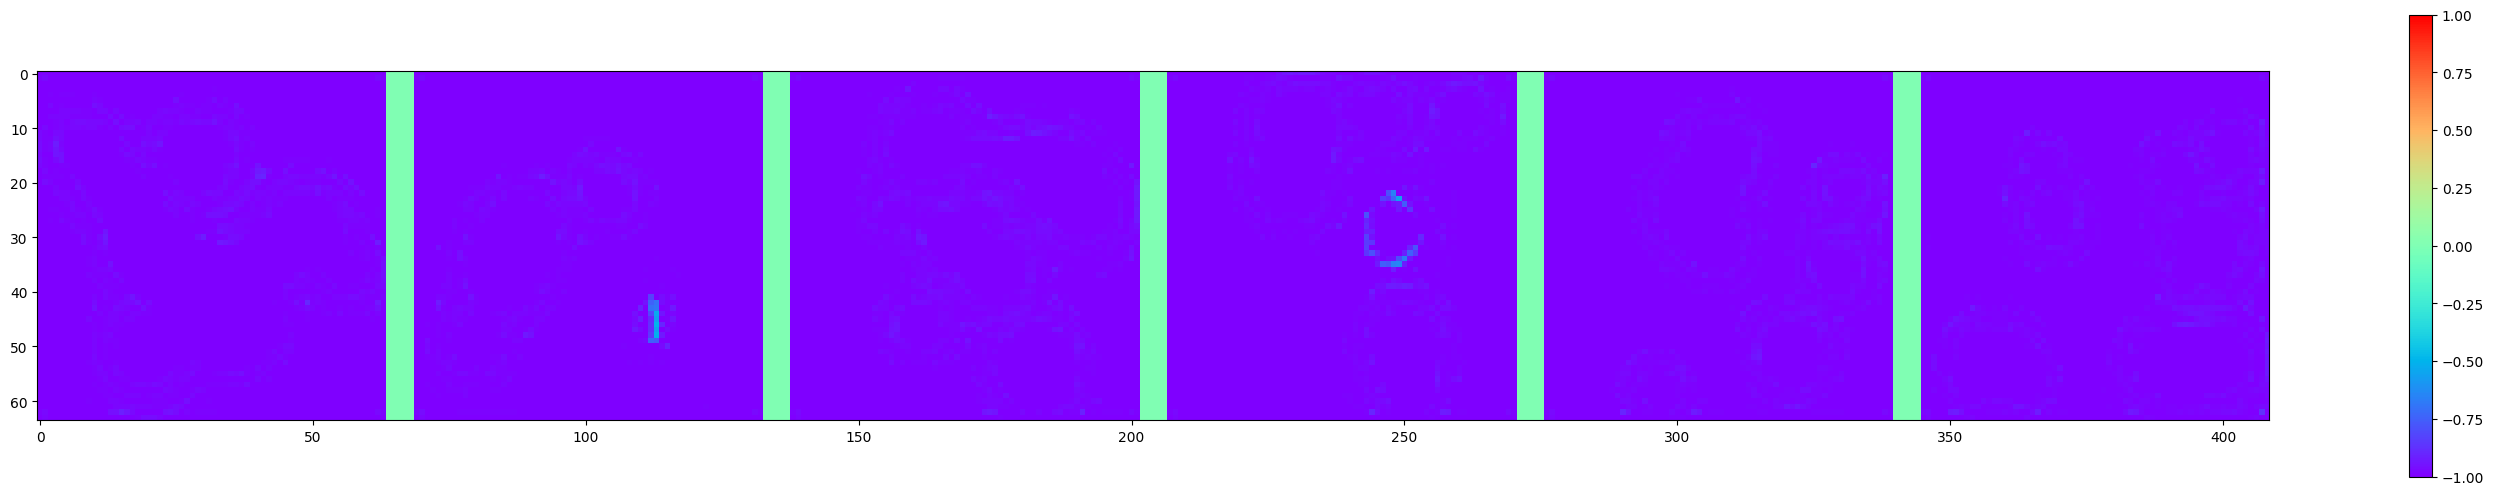

In [38]:
fcn.eval()
input,  target, fulltarget  = gen2(6, p)

fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

input = input.cuda()

output = fcn(input)

output = output.cpu().detach()

fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(output, 6, fig1, k=0, min_scale=-1,max_scale=1)


Le réseau restitue le champ d'entrée car le champ d'entrée contient l'information qui se trouve dans la cible. L'apprentissage est caduque et renvoie une information déjà connue.

On cherche maintenant à utiliser une partie des observations ponctuelles comme prédicteurs.\
Une idée simple consiste à définir un deuxième tenseur d'entrée ne comptant (environ) qu'une observation ponctuelle sur deux. Les autres observations ponctuelles sont quant elles utilisées comme cible.

**Q3** Mettre en oeuvre cette idée.

**Remarques:**
- La fonction *torch.bernoulli* permet de masquer environ 50% des valeurs d'un tenseur...
- Attention à la mutabilité des tenseurs pytorch.

In [ ]:
...

**Q4** Procéder à un apprentissage sur dix époques, comparer la courbe d'apprentissage obtenue avec la précédente et expliquer.

In [ ]:
nepochs = 15
fcn = UNet(2,1,16).cuda()

...

In [ ]:
scores_2  = []

...

**Q5** Visualiser des batches d'outputs. Dans quelle mesure le réseau parvient-il à lever l'ambiguïté sur le type de cellule en présence ?

In [ ]:
fcn.eval()
input,  target, fulltarget  = gen2(6, p = 0.005)

# prédicteur spatialisé
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# obs ponctuelles et cible complète
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D((target>=0) + fulltarget, 6, fig1, k=0, min_scale=0.,max_scale=1)

output = ...

...

**Q6** Au cours d'un apprentissage, nous avons utilisé (environ) la moitié des observations ponctuelles à disposition. Quel peut être le défaut de cette approche ? Jouer sur la valeur de *p* pour illustrer votre propos.

**Q7** Pour prédire la valeur d'un pixel, un FCN permet de prendre en compte le contexte, c'est à dire l'information contenue dans un large voisinage autour du pixel d'intérêt.\
Cette qualité était-elle nécessaire pour traiter la **partie I** du problème ? Etait-elle nécessaire pour traiter la **partie II** ? Justifier dans les deux cas.